In [215]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import itertools
import math
import re
# NLP library to get stop words for english
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from time import time

import warnings
warnings.filterwarnings('ignore')

# for supervised learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


# Introduction

This week for Unsupervised Algorithms, the assignment is to complete a mini-project regarding the BBC News Classification competition here on Kaggle. This competition revolves around classifying different BBC articles into one of five different categories, including the following: business, tech, politics, sport, and entertainment. For our class, we'll specifically be looking to use matrix factorization when it comes to the prediction, and use any type of NLP processing we would like. Admittedly, this will be one of my first delves into NLP at this level, so please keep that in mind.

## EDA

The first thing I will do in the EDA is to look at what the train and test sets look like.

In [216]:
train = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Train.csv")
test = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Test.csv")
sample_solution_df = pd.read_csv("/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv")
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [217]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


Based on the above info, both the train and test sets will have three different columns, an ID column, the text of the article, and the category that the article falls into. Below, we can see how the training set articles are broken down by category:

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64


<AxesSubplot:>

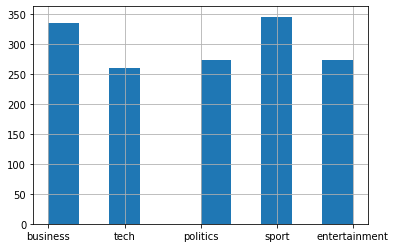

In [218]:
print(train['Category'].value_counts())
train['Category'].hist()

From the above plot we can see that the data is relatively balanced in terms of the categories, which is good for training purposes. We'll also want to remove any duplicates in the training set.

In [219]:
train = train.drop_duplicates(subset = ['Text', 'Category'])

In [220]:
train.shape

(1440, 3)

Based on the change in shape it looks like about 50 overall duplicates have been removed, which we can also in the histogram below. It looks like most of the duplicate articles came from the sports and tech categories, though the data is still balanced overall.

sport            342
business         335
politics         266
entertainment    263
tech             234
Name: Category, dtype: int64


<AxesSubplot:>

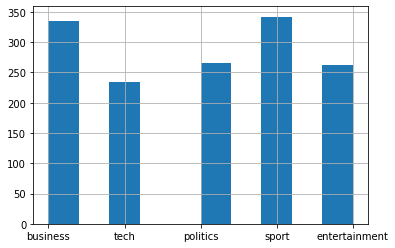

In [221]:
print(train['Category'].value_counts())
train['Category'].hist()

In [222]:
word_count_hist = train
word_count_hist['counts'] = train['Text'].str.split().str.len()
word_count_hist.head()

,ArticleId,Text,Category,counts
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301
1,154,german business confidence slides german busin...,business,325
2,1101,bbc poll indicates economic gloom citizens in ...,business,514
3,1976,lifestyle governs mobile choice faster bett...,tech,634
4,917,enron bosses in $168m payout eighteen former e...,business,355


         ArticleId       counts
count  1440.000000  1440.000000
mean   1118.146528   385.215972
std     642.822120   212.167106
min       2.000000    90.000000
25%     560.750000   253.000000
50%    1111.000000   337.000000
75%    1681.250000   468.250000
max    2224.000000  3345.000000


<AxesSubplot:>

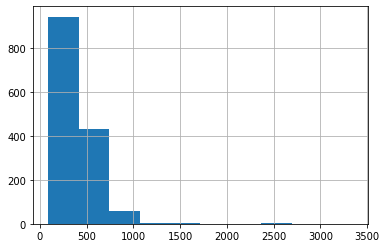

In [223]:
print(word_count_hist.describe())
word_count_hist['counts'].hist()

Looking at the counts of the words in the articles, we see that the vast majority of articles have less than 500 words. This makes sense, as most articles will want to be succinct to catch a readers attention for a brief period. Taking a look below, it looks like the tech articles are usually the longest, with the average word count being around 509 words per article.

In [224]:
grouped_word = word_count_hist[['Category','counts']].groupby(['Category'])
grouped_word.describe()

counts                                                        \
               count        mean         std    min     25%    50%     75%   
Category                                                                     
business       335.0  334.274627  133.713125  145.0  253.00  304.0  391.50   
entertainment  263.0  335.444867  207.134549  144.0  229.00  271.0  380.00   
politics       266.0  451.642857  261.490785   90.0  320.25  445.0  527.75   
sport          342.0  336.877193  185.930006  116.0  211.50  296.5  416.75   
tech           234.0  509.222222  212.922747  188.0  345.25  461.5  633.75   

                       
                  max  
Category               
business        902.0  
entertainment  2448.0  
politics       3345.0  
sport          1671.0  
tech           1549.0

Category
business         [[AxesSubplot(0.125,0.125;0.775x0.755)]]
entertainment    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
politics         [[AxesSubplot(0.125,0.125;0.775x0.755)]]
sport            [[AxesSubplot(0.125,0.125;0.775x0.755)]]
tech             [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

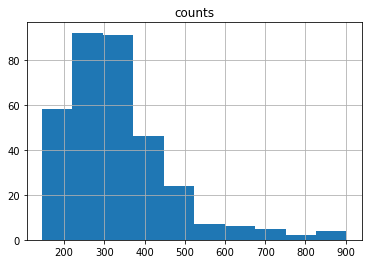

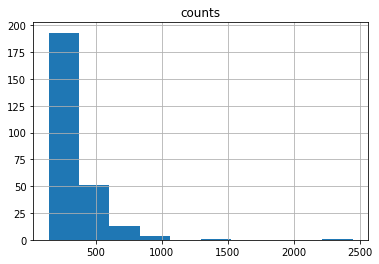

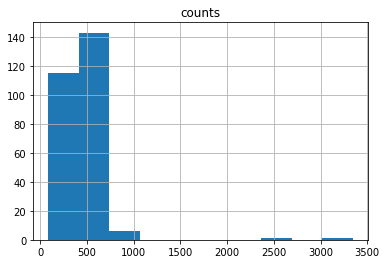

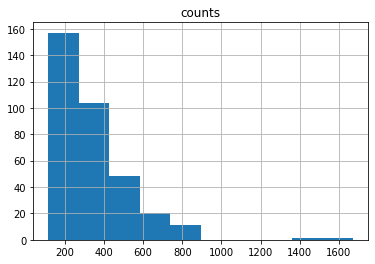

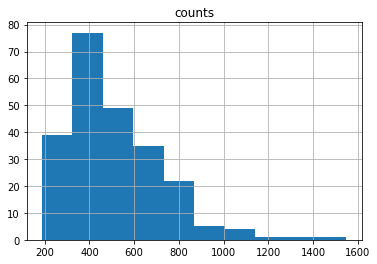

In [225]:
grouped_word.hist()

With the last bit of EDA, we will want to go ahead and change the category to a numeric value rather than the strings that they are right now. This comes from a pracitce I found here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html.

In [226]:
labelChange = LabelEncoder()
train['Category_Number'] = labelChange.fit_transform(train['Category'])
train.head()

,ArticleId,Text,Category,counts,Category_Number
0,1833,worldcom ex-boss launches defence lawyers defe...,business,301,0
1,154,german business confidence slides german busin...,business,325,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,514,0
3,1976,lifestyle governs mobile choice faster bett...,tech,634,4
4,917,enron bosses in $168m payout eighteen former e...,business,355,0


## Building and Training the Models

The first thing I will do is to split the data into train and validation splits from the training dataset. For the model itself, I will look to use a NMF model. However, before we can jump into that, we need to tokenize the texts of the articles into the weights of particular words. We'll also remove "stop" words from the texts, words that are articles or pronouns. To do so, I'll utilize the TF-IDF vectorizer. This is the first time I've used this vectorizer, and the general idea is that this vectorizer looks at all of the articles' texts, and weights individual words based on how often they show up in a category. Then, the NMF model can use these weights to determine which words represent a particular category, and will predict a specific category based on those weights. Here are some links to understand more about both TF-IDF and NMF: http://www.tfidf.com/, https://predictivehacks.com/topic-modelling-with-nmf-in-python/. The code below is representative of the sklearn information found here: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html and here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html.

In [227]:
X_train, X_test, y_train, y_test = train_test_split(train['Text'], train['Category_Number'], test_size=0.2, random_state=42)

It's not super common to split the data into training and validation sets in unsupervised models, but since we actually have categories here I think it makes sense to not have the all of the training data in there for our model, much less the test set.

In [228]:
num_feat = 10
## Setting up TFIDF and NMF models
# Removing stop words, and requiring a word to be in at least 5 articles to be included
# num_feats is set to 10 to only include the top 10 words in the weights, otherwise the vectorizer will run slower
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df = 5, max_features=num_feat, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nmf = NMF(n_components=5, random_state=42, alpha=.25, l1_ratio=.5).fit(tfidf)

nmf_trans = nmf.fit_transform(tfidf)

Now that we have the NMF model, lets look at the top 10 words from each category:

In [229]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
said people government uk time year world new mr film
Topic 1:
mr government said uk people world year time new film
Topic 2:
year time world said uk government new people mr film
Topic 3:
film year uk said time mr world people new government
Topic 4:
new people uk world said time year mr government film


In [230]:
components_df = pd.DataFrame(nmf.components_, columns=tfidf_vectorizer.get_feature_names())
components_df.head()

for topic in range(components_df.shape[0]):
    tmp = components_df.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 0 the words with the highest value are:
said          7.215435
people        0.888385
government    0.571243
uk            0.350755
time          0.292511
year          0.094474
film          0.000000
mr            0.000000
new           0.000000
world         0.000000
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
mr            5.481121
government    1.576387
said          0.671335
uk            0.429757
people        0.415021
world         0.184345
year          0.023139
film          0.000000
new           0.000000
time          0.000000
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
year          5.089488
time          2.765303
world         2.254956
said          0.399270
uk            0.138048
government    0.027245
new           0.020462
film          0.000000
mr            0.000000
people        0.000000
Name: 2, dtype: float64


For topic 3 the words with the highest value are:
film          4.399638
year     

From the two above chunks of code, we can see that the values of topics are the following: 
0 = sport
1 = politics
2 = tech
3 = entertainment
4 = business
For now, we will just check to see what the accuracy will be like based on the general predictions rather than implying that our manual predictions of each category is correct. For the test/submission data set we will want to actually utilize this mapping.

In [231]:
accuracy_score(y_train, pd.DataFrame(np.argmax(nmf_trans, axis=1)[:]))

0.1684027777777778

With an accuracy of just 0.168 in this first model, there's obviously some space to grow from a model standpoint. In the next section, I will look to tune hyperparameters in order to find the best model for the final submission.

## Hyper Parameter Tuning

For the hyper-parameter tuning, I will look into the number of features in the TF-IDF Vectorizer, and the alpha W and L1 Ratio for the NMF model.

In [232]:
param_tuning_results = pd.DataFrame(columns = ['num_features','alpha_W','l1_ratio', 'accuracy'])
t0 = time()
for num_feat in np.arange(5, 105, 5):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df = 5, max_features=num_feat, stop_words = 'english')
    tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
    for alpha_w in np.arange(0, 1.25, 0.25):
        for l1_ratio in np.arange(0, 1.25, 0.25):
            nmf = NMF(n_components = 5, random_state=42, alpha_W= alpha_w, alpha_H = 'same', l1_ratio= l1_ratio)
            nmf_trans = nmf.fit_transform(tfidf)
            yset = y_train[:]
            yset = pd.DataFrame(yset)
            yset['Category'] = 'sport'
            for i in range(0,len(yset)):
                if yset['Category_Number'].iloc[i] == 1:
                    yset['Category'].iloc[i] = 'politics'
                elif yset['Category_Number'].iloc[i] == 2:
                    yset['Category'].iloc[i] = 'tech'
                elif yset['Category_Number'].iloc[i] == 3:
                    yset['Category'].iloc[i] = 'entertainment'
                elif yset['Category_Number'].iloc[i] == 4:
                    yset['Category'].iloc[i] = 'business'
            y_hat = np.argmax(nmf_trans, axis=1)
            y_hat = pd.DataFrame(y_hat)
            y_hat['Category'] = 'sport'
            for i in range(0,len(y_hat)):
                if y_hat[0][i] == 1:
                    y_hat['Category'][i] = 'politics'
                elif y_hat[0][i] == 2:
                    y_hat['Category'][i] = 'tech'
                elif y_hat[0][i] == 3:
                    y_hat['Category'][i] = 'entertainment'
                elif y_hat[0][i] == 4:
                    y_hat['Category'][i] = 'business'
            acc = accuracy_score(yset['Category'], y_hat['Category'])
            param_tuning_results.loc[len(param_tuning_results.index)] = [num_feat, alpha_w, l1_ratio, round(acc, 3)]
print("done in %0.3fs." % (time() - t0))

done in 278.967s.


In [233]:
param_tuning_results.head()

,num_features,alpha_W,l1_ratio,accuracy
0,5.0,0.0,0.00,0.336
1,5.0,0.0,0.25,0.336
2,5.0,0.0,0.50,0.336
3,5.0,0.0,0.75,0.336
4,5.0,0.0,1.00,0.336


Based on the above results I want to find where the accuracy is maximized so we know to use those hyperparameters for the final model:

In [234]:
param_tuning_results[param_tuning_results['accuracy'] == param_tuning_results['accuracy'].max()]

,num_features,alpha_W,l1_ratio,accuracy
375,80.0,0.0,0.00,0.488
376,80.0,0.0,0.25,0.488
377,80.0,0.0,0.50,0.488
378,80.0,0.0,0.75,0.488
379,80.0,0.0,1.00,0.488


## Preparation for Submission

From the testing above, we can see that the hyper-parameters we need to use are 80 as the number of features,  0.0 as the alpha W, and 0.00 as the L1 Ratio. 

We'll create the TF-IDF Vectorizer and NMF Model below:

In [235]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df = 5, max_features=80, stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(test['Text']).toarray()
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

nmf = NMF(n_components = 5, random_state=42, alpha_W=0, alpha_H = 'same', l1_ratio=0)
nmf_trans = nmf.fit_transform(tfidf)

In [237]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
game win play players england games said world time good
Topic 1:
mr labour said government election party blair minister told public
Topic 2:
said people company new firm technology use market news make
Topic 3:
film best music tv year won british new number industry
Topic 4:
year growth economy 2004 sales said government market expected 000


Just to confirm our previous topics and assumptions above, the above topics were shown once again. Since nothing has changed in that department, let's recode the categories below just to be sure:

In [238]:
y_hat = np.argmax(nmf_trans, axis=1)

y_hat = pd.DataFrame(y_hat)
y_hat['Category'] = 'sport'
for i in range(0,len(y_hat)):
    if y_hat[0][i] == 1:
        y_hat['Category'][i] = 'politics'
    elif y_hat[0][i] == 2:
        y_hat['Category'][i] = 'tech'
    elif y_hat[0][i] == 3:
        y_hat['Category'][i] = 'entertainment'
    elif y_hat[0][i] == 4:
        y_hat['Category'][i] = 'business'
        
y_hat.head()


,0,Category
0,0,sport
1,2,tech
2,0,sport
3,2,tech
4,0,sport


Finally, the submission has been created in a csv utilizing the above models.

In [239]:
submit = test[:]
submit['Category'] = y_hat['Category']
submit.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads for preston queens park r...,sport
1,1319,software watching while you work software that...,tech
2,1138,d arcy injury adds to ireland woe gordon d arc...,sport
3,459,india s reliance family feud heats up the ongo...,tech
4,1020,boro suffer morrison injury blow middlesbrough...,sport


In [240]:
submit = submit[['ArticleId', 'Category']]
submit.to_csv("submission.csv",index=False)


## Supervised Learning Comparison

Since we have labels in the data, this is likely a case wehere we should be utilizing the supervised learning methods that we learned in the previous class. I will compute a Random Forest Classifier utilizing the same TF-IDF vectorizer that we had earlier to see if the model performs at a more reasonable accuracy level.

In [241]:
# Utilizing previous TFIDF Vect, create a RF Classifier at a max_depth of 5. 
X_trainRF = tfidf_vectorizer.transform(X_train)
y_trainRF = labelChange.fit_transform(y_train)
X_testRF = tfidf_vectorizer.transform(X_test)
y_testRF = labelChange.fit_transform(y_test)
random_forest = RandomForestClassifier(max_depth=5, random_state=42)
RFModel = random_forest.fit(X_trainRF, y_trainRF)
pred = RFModel.predict(X_testRF)
acc = accuracy_score(y_testRF, pred)

print(acc)


0.84375


As we can see, the accuracy of an un-optimized RF Classifier at a depth of 5 already performs with a better accuracy of 0.844 compared to our previous model's 0.488 accuracy. Below, I'll explore the training set size to see at what point we overfit.

In [242]:
for i in np.arange(0.1, 0.7,.1):
    X_train, X_test, y_train, y_test = train_test_split(train['Text'], train['Category_Number'], test_size=i, random_state=42)
    X_trainRF = tfidf_vectorizer.transform(X_train)
    y_trainRF = labelChange.fit_transform(y_train)
    X_testRF = tfidf_vectorizer.transform(X_test)
    y_testRF = labelChange.fit_transform(y_test)
    random_forest = RandomForestClassifier(max_depth=5, random_state=42)
    RFModel = random_forest.fit(X_trainRF, y_trainRF)
    pred = RFModel.predict(X_testRF)
    acc = accuracy_score(y_testRF, pred)
    print(i)
    print(acc)


0.1
0.8402777777777778
0.2
0.84375
0.30000000000000004
0.8244803695150116
0.4
0.8177083333333334
0.5
0.8194444444444444
0.6
0.7974537037037037


It looks like the overfitting starts happening after we utilize any more than 20% of the data for our test size. This tracks with what we learned in the last class as well. It seems that this model is also more computationally efficient, though this would require further examination.

## Conclusion

Overall we were able to create a model with roughly 0.488 accuracy utilizing an unsupervised approach. For the supervised model that was created, the accuracy was much higher, at an accuracy level of 0.844, with a seemingly more efficient computation time as well. This doesn't discount the validity of unsupervised learning, but more so just points out that some data sets are better suited to a supervised approach.